In [5]:
from pathlib import Path

import gym
from gym import spaces
from rljax.algorithm import DQN, FQF, SAC_Discrete
from rljax.trainer import Trainer
import numpy as np
import pandas as pd

from classes import Env, Preprocess

PATH = Path().cwd()

In [6]:
raw = Preprocess(PATH.joinpath('asset_data', 'TBT_UBT_data.csv'))
data = raw.process()

In [7]:
def sniper(state_1, state_2, env, start_state):
    state = start_state
    done = False
    all_rewards = list()
    while not done:
        if state[0] == state_1:
            state, reward, done, _ = env.step(0)
        elif state[0] == state_2:
            state, reward, done, _ = env.step(1)
        else:
            state, reward, done, _ = env.step(2)
        all_rewards.append(reward)
    return all_rewards

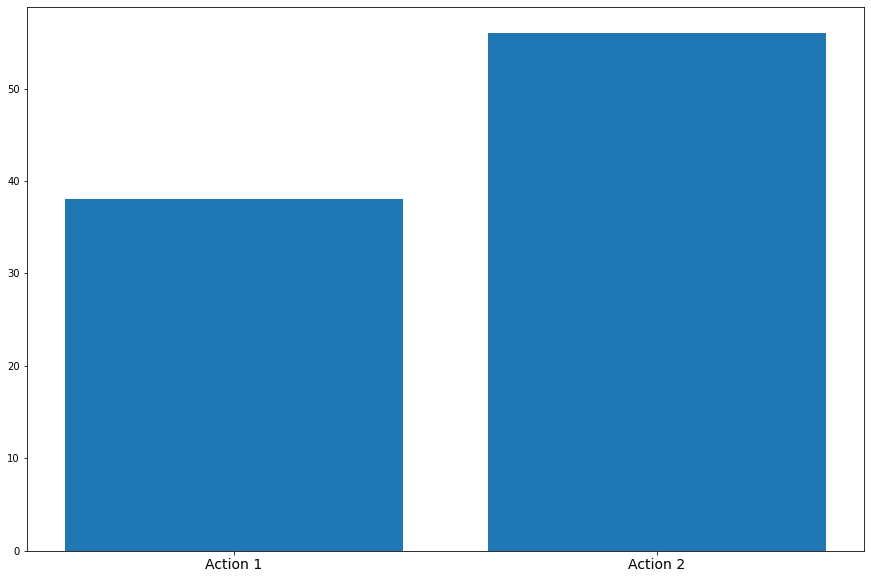

In [16]:
env = Env(data, no_trade_period=10, steps=2000)
mappings = env.mapping
sniper(mappings['220'], mappings['302'], env, env.reset())
sniper(mappings['220'], mappings['302'], env, env.reset())
env.summarize_state_decisions('302')

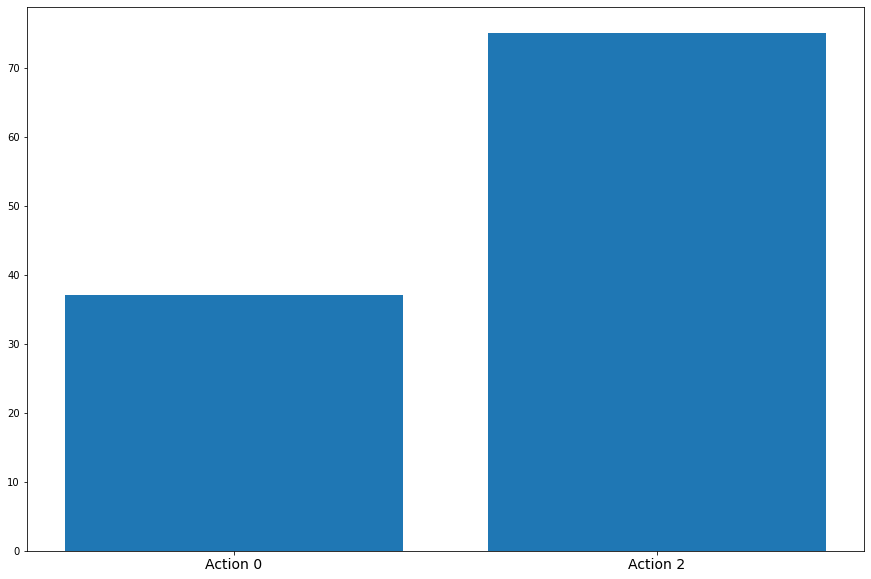

In [17]:
env.summarize_state_decisions('220')

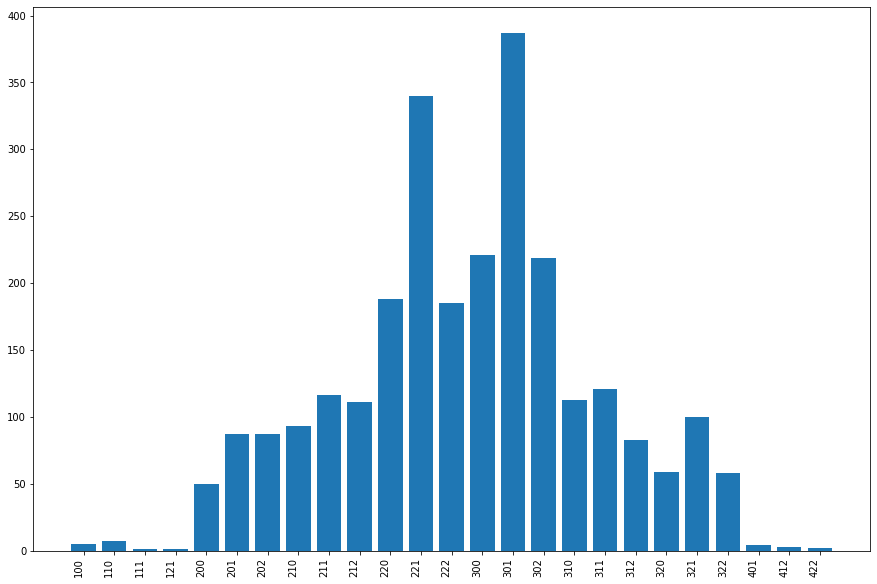

In [18]:
env.plot_state_frequency()

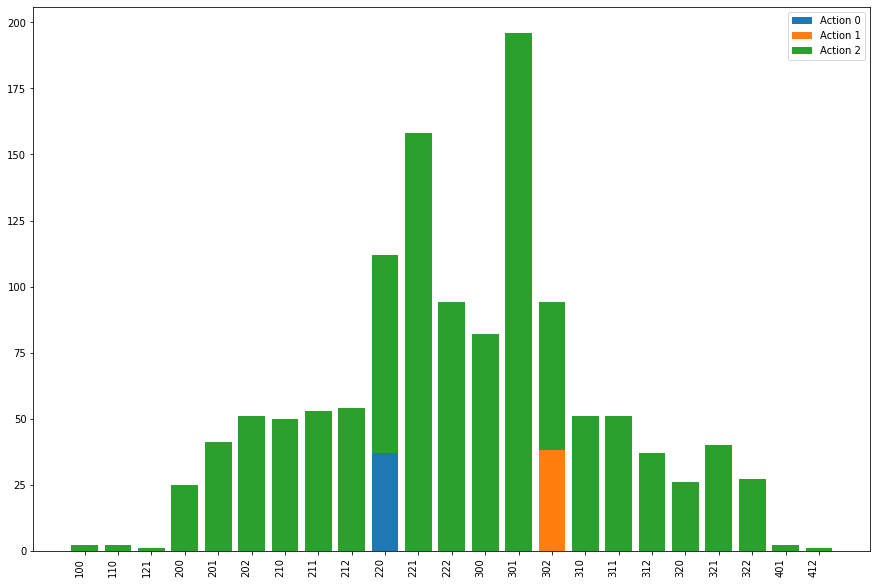

In [19]:
env.summarize_decisions()

In [23]:
def return_rewards(current, last, action, p, c):
    return sum(current) - sum(last)

In [32]:
# 23,400 seconds between 9:30am and 4pm broken in 10 second increments

NUM_AGENT_STEPS = 40000
SEED = 0
DAYS = 2
DAY = 2340

env = Env(data, no_trade_period=5, steps=DAY*DAYS, reward_func=return_rewards)
env_test = Env(data, no_trade_period=5, steps=DAY*DAYS, reward_func=return_rewards)

algo = SAC_Discrete(
    num_agent_steps=NUM_AGENT_STEPS,
    state_space=env.state_space,
    action_space=env.action_space,
    seed=SEED,
    batch_size=256,
    start_steps=1000,
    update_interval=1,
    update_interval_target=400,
#     eps_decay_steps=0,
#     loss_type="l2",
#     lr=1e-3,
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    log_dir="",
    num_agent_steps=NUM_AGENT_STEPS,
    eval_interval=1000,
    seed=SEED,
)
trainer.train()

Num steps: 1000     Return: 2.8     Time: 0:01:28
Num steps: 2000     Return: 34.7    Time: 0:02:33
Num steps: 3000     Return: 11.1    Time: 0:04:18
Num steps: 4000     Return: 7.9     Time: 0:05:43
Num steps: 5000     Return: 44.0    Time: 0:07:04
Num steps: 6000     Return: 37.1    Time: 0:08:16
Num steps: 7000     Return: 31.6    Time: 0:09:20
Num steps: 8000     Return: 32.1    Time: 0:10:34
Num steps: 9000     Return: 29.9    Time: 0:11:40
Num steps: 10000    Return: 46.5    Time: 0:12:52
Num steps: 11000    Return: 44.9    Time: 0:14:09
Num steps: 12000    Return: 39.4    Time: 0:15:16
Num steps: 13000    Return: 45.9    Time: 0:16:25
Num steps: 14000    Return: 36.2    Time: 0:17:31
Num steps: 15000    Return: 40.3    Time: 0:18:40
Num steps: 16000    Return: 35.8    Time: 0:19:51
Num steps: 17000    Return: 42.8    Time: 0:21:01
Num steps: 18000    Return: 45.7    Time: 0:22:08


KeyboardInterrupt: 

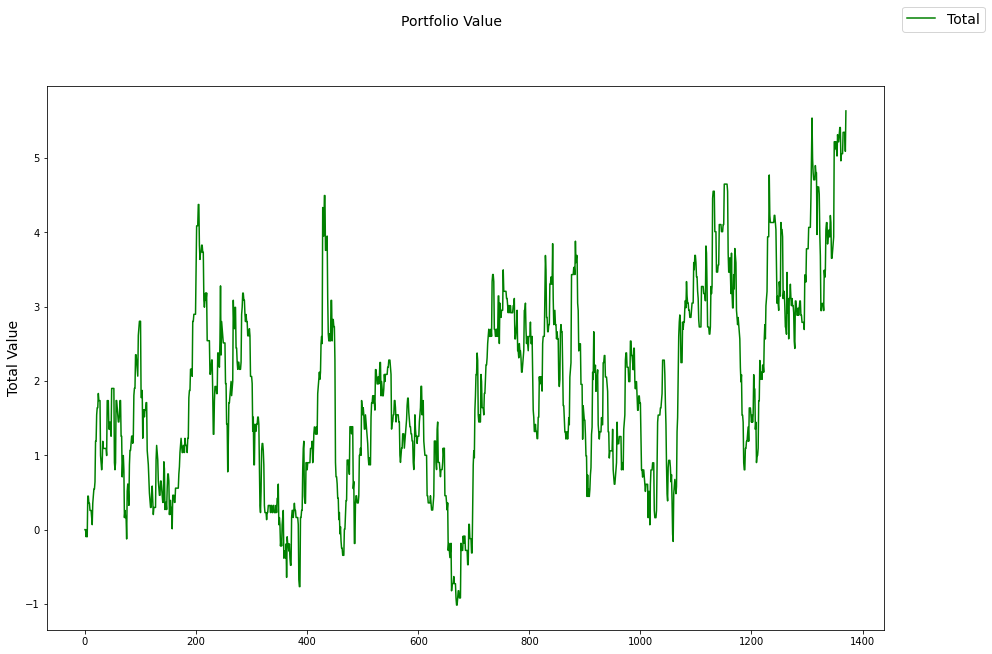

In [39]:
env.plot()

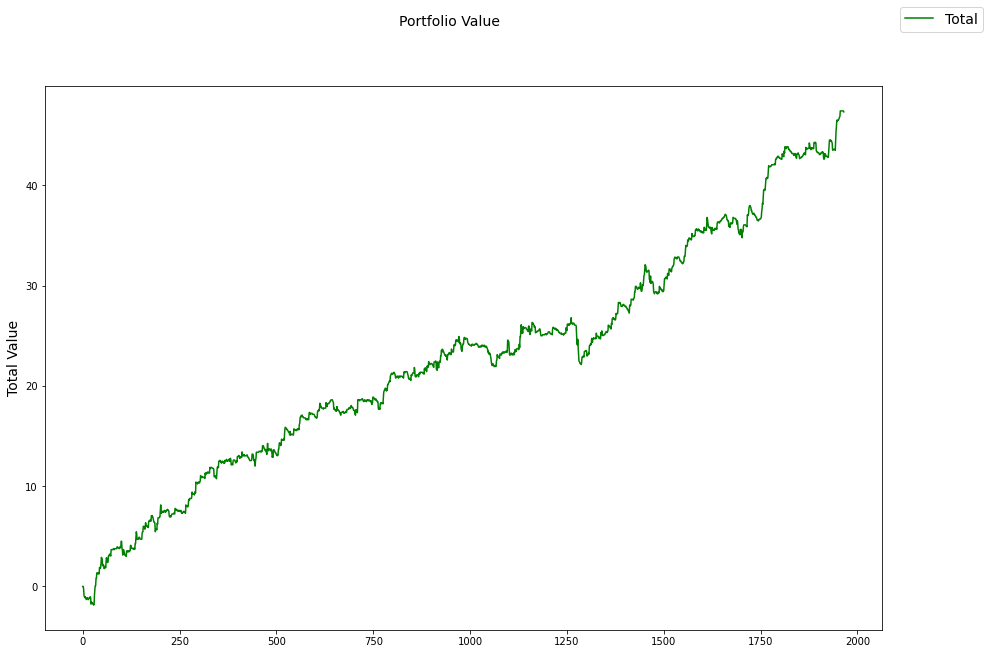

In [36]:
env_test.plot()

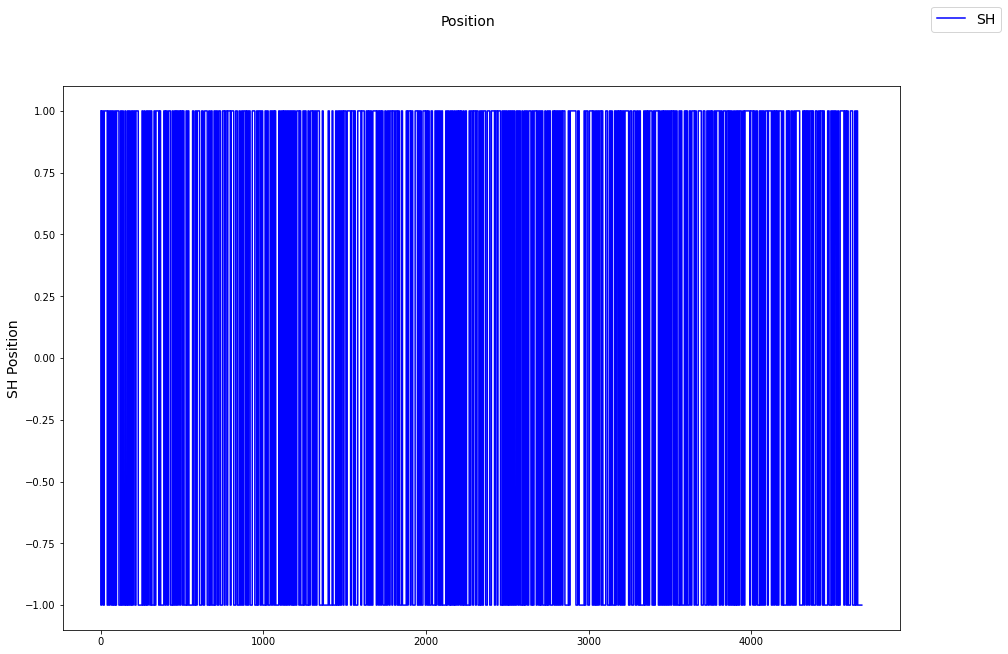

In [37]:
env_test.plot('position_history')

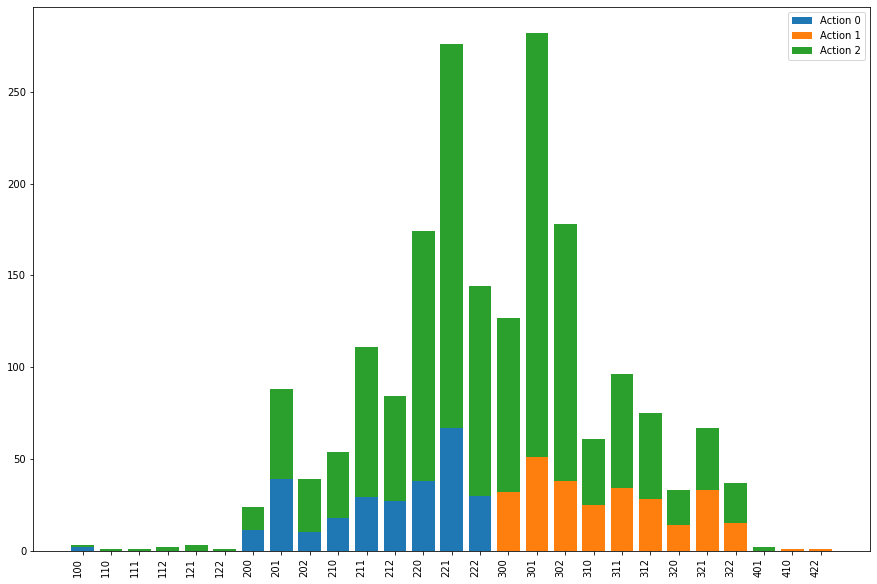

In [38]:
env_test.summarize_decisions()